In [1]:
#import and show data
import os
import glob
import menpo.io as mio
from menpo.visualize import print_progress
from menpo.landmark import labeller, face_ibug_68_to_face_ibug_68_trimesh
from menpowidgets import visualize_images
from menpofit.aam import HolisticAAM
from menpofit.aam import PatchAAM
from menpo.feature import fast_dsift
from menpo.feature import igo
from menpofit.aam import LucasKanadeAAMFitter, WibergInverseCompositional
%matplotlib inline


def process(image, crop_proportion=0.2, max_diagonal=400):
    if image.n_channels == 3:
        image = image.as_greyscale()
    image = image.crop_to_landmarks_proportion(crop_proportion)
    d = image.diagonal()
    if d > max_diagonal:
        image = image.rescale(float(max_diagonal) / d)
    
    labeller(image, 'PTS', face_ibug_68_to_face_ibug_68_trimesh)
    return image

path_to_database = '/Programing/GR/dataset/lfpw/trainset'
#print(mio.input.base.glob_with_suffix(path_to_database))
training_images = []
for img in print_progress(mio.import_images(path_to_database, verbose=True)):
    training_images.append(process(img))

#visualize_images(training_images)

aam = HolisticAAM(training_images, group='face_ibug_68_trimesh', diagonal=150,
                  scales=(0.5, 1.0), holistic_features=fast_dsift, verbose=True,
                  max_shape_components=20, max_appearance_components=150)

#aam = PatchAAM(training_images, group='PTS', patch_shape=[(15, 15), (23, 23)],
#                     diagonal=150, scales=(0.5, 1.0), holistic_features=fast_dsift,
#                     max_shape_components=20, max_appearance_components=150,
#                     verbose=True)

#aam.view_shape_models_widget()

from menpofit.aam import LucasKanadeAAMFitter, WibergInverseCompositional

fitter = LucasKanadeAAMFitter(aam, lk_algorithm_cls=WibergInverseCompositional,
                              n_shape=[5, 20], n_appearance=[30, 150])
#print(fitter)


Found 811 assets, index the returned LazyList to import.
[====================] 100% (811/811) - done.                                   
- Computing reference shape                                                     Computing batch 0
- Building models
  - Scale 0: Done
  - Scale 1: Done
                                                              

D:\Programs\Anaconda\envs\GR\lib\site-packages\menpo\image\base.py:2652: MenpoDeprecationWarning: This method is no longer supported and will be removed in a future version of Menpo. Use .pixels_with_channels_at_back instead.
  MenpoDeprecationWarning)


1 detected faces.


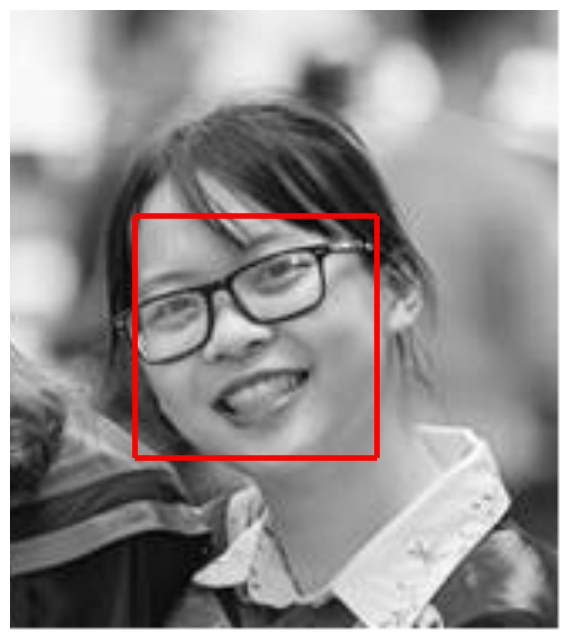

In [4]:
from pathlib import Path
import menpo.io as mio
from menpodetect import load_dlib_frontal_face_detector

path_to_test = Path('/Programing/GR/Code/CK+/test_images')

image = mio.import_image(path_to_test / '16.png')

d = image.diagonal()


if image.n_channels == 3:
        image = image.as_greyscale()
        

# Load detector
detect = load_dlib_frontal_face_detector()

# Detect
bboxes = detect(image)
print("{} detected faces.".format(len(bboxes)))

# View
if len(bboxes) > 0:
    image.view_landmarks(group='dlib_0', line_colour='red',
                         render_markers=False, line_width=4);
    

D:\Programs\Anaconda\envs\GR\lib\site-packages\menpo\image\base.py:2652: MenpoDeprecationWarning: This method is no longer supported and will be removed in a future version of Menpo. Use .pixels_with_channels_at_back instead.
  MenpoDeprecationWarning)


Fitting result of 68 landmark points.


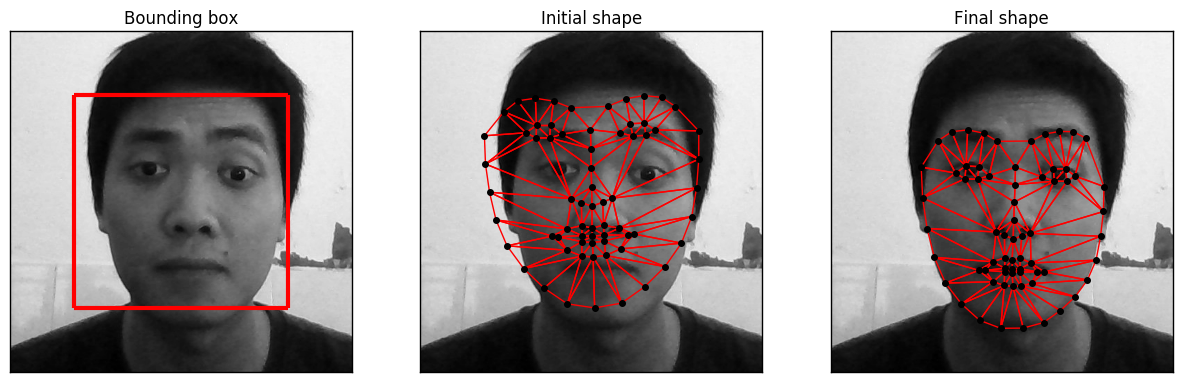

In [5]:
#harder head pose detection
import matplotlib.pyplot as plt
from pathlib import Path
import menpo.io as mio
from menpodetect import load_dlib_frontal_face_detector

path_to_test = Path('/Programing/GR/Code/CK+/test_images')

# Load and convert to grayscale
image = mio.import_image(path_to_test / '16.jpg')
if image.n_channels == 3:
        image = image.as_greyscale()
# Detect face

detect = load_dlib_frontal_face_detector()
bboxes = detect(image)

# Crop the image for better visualization of the result
image = image.crop_to_landmarks_proportion(0.3, group='dlib_0')
bboxes[0] = image.landmarks['dlib_0'].lms

if len(bboxes) > 0:
    # Fit AAM
    result = fitter.fit_from_bb(image, bboxes[0], max_iters=[50, 5])
    print(result)

    # Visualize
    plt.subplot(131);
    image.view()
    bboxes[0].view(line_width=3, render_markers=False)
    plt.gca().set_title('Bounding box')

    plt.subplot(132)
    image.view()
    result.initial_shape.view(marker_size=4)
    plt.gca().set_title('Initial shape')

    plt.subplot(133)
    image.view()
    result.final_shape.view(marker_size=4, figure_size=(15, 13))
    plt.gca().set_title('Final shape')

In [26]:
print(dir(result))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_appearance_parameters', '_costs', '_final_shape', '_gt_shape', '_image', '_initial_shape', '_n_iters', '_n_iters_per_scale', '_n_scales', '_reconstruction_indices', '_shape_parameters', '_shapes', 'appearance_parameters', 'costs', 'displacements', 'displacements_stats', 'errors', 'final_error', 'final_shape', 'gt_shape', 'image', 'initial_error', 'initial_shape', 'is_iterative', 'n_iters', 'n_iters_per_scale', 'n_scales', 'plot_costs', 'plot_displacements', 'plot_errors', 'reconstructed_initial_error', 'reconstructed_initial_shapes', 'shape_parameters', 'shapes', 'to_result', 'view', 'view_iterations', 'view_widget']


In [74]:
for point in result.final_shape.points:
    print(point)

[ 123.00124932   64.90592375]
[ 147.75528413   65.15694385]
[ 174.32547318   66.40915313]
[ 200.93599454   67.28555012]
[ 225.35314178   73.20754799]
[ 246.65585118   87.22275961]
[ 265.16930261  104.83877123]
[ 281.19903994  127.90955221]
[ 285.39161288  157.36062822]
[ 281.13405479  186.42649055]
[ 264.14650323  208.90840065]
[ 243.95723589  225.76945241]
[ 220.87706645  237.98898086]
[ 196.67258376  244.25130526]
[ 172.63210013  246.54276581]
[ 149.75573379  247.76860567]
[ 126.72162754  248.37256525]
[ 93.71699076  78.82042435]
[ 83.80972567  91.90014884]
[  83.62768209  108.50684698]
[  86.92739807  124.83140695]
[  94.57874151  139.66236213]
[  93.82232697  171.23282807]
[  87.37724537  186.53279209]
[  85.20822084  202.05712226]
[  86.4001485  218.01914  ]
[  96.13741983  229.52963207]
[ 119.73896584  155.53734014]
[ 136.89065559  155.40352516]
[ 154.06196953  155.08454184]
[ 171.41368584  154.70858838]
[ 176.5189926   129.38616193]
[ 181.47770894  141.18649786]
[ 186.80764488  

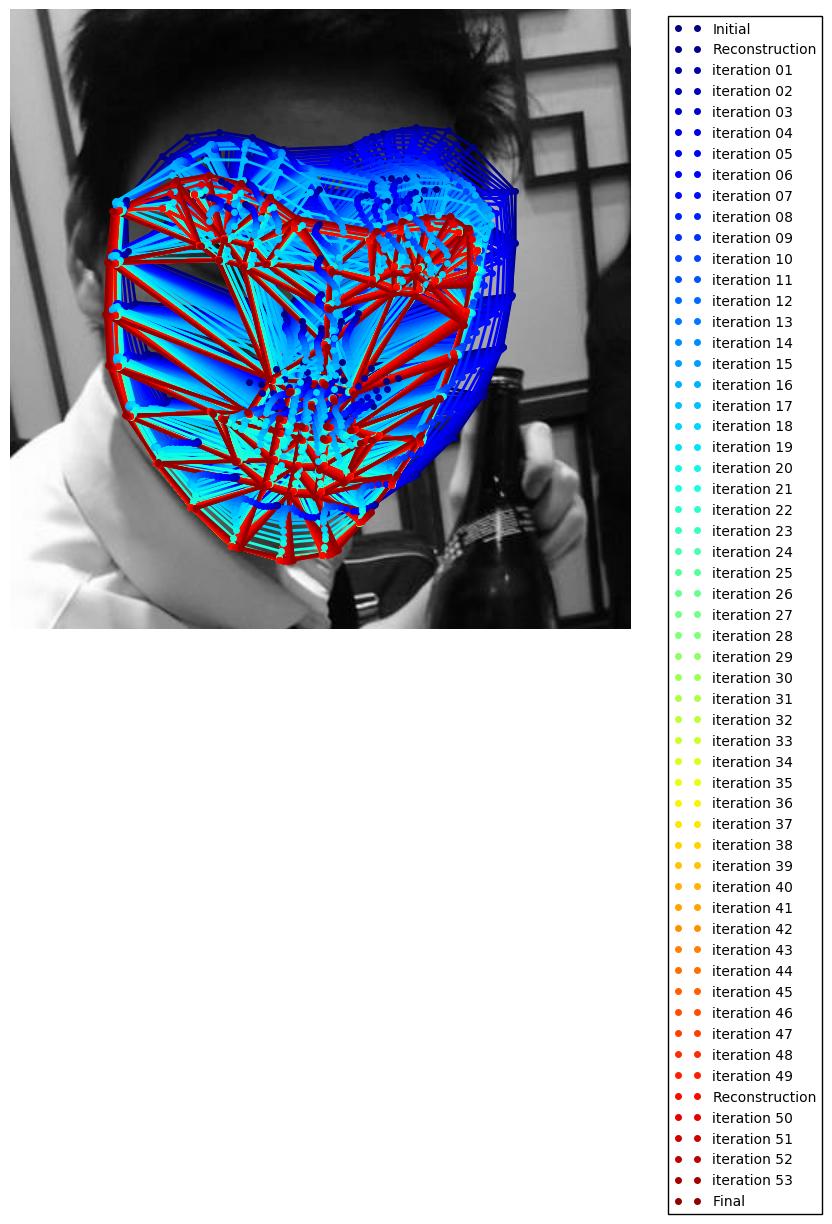

In [4]:
result.view_iterations()

AttributeError: 'TriMesh' object has no attribute 'lms'